In [31]:
import numpy as np
import torch

class LatticeBoltzmannSimulator:
    def __init__(self, grid, tau, ic=None, bc=None,inlet=None):
        self.nx, self.ny,_ = grid.shape
        self.tau = tau
        self.grid = grid
        self.ic = ic
        self.bc = bc
        self.inlet=inlet
        # Initialize velocity vectors for D2Q9
        self.e = torch.tensor([[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1], 
                               [1, 1], [-1, 1], [-1, -1], [1, -1]], dtype=torch.float32)
        self.w = torch.tensor([4/9] + [1/9]*4 + [1/36]*4, dtype=torch.float32)
        self.initialize_grid()

    def initialize_grid(self):
        # Initialize f at equilibrium with a given macroscopic density rho and velocity u
        rho = torch.ones((self.nx, self.ny), dtype=torch.float32)  # Example density
        if self.ic==None:
            print('no initial cond')
            u = torch.zeros((self.nx, self.ny, 2), dtype=torch.float32)  # Example velocity field (u, v) for each point
        else: 
            u=self.ic
        self.f = self.equilibrium_distribution(rho, u)
        

    def equilibrium_distribution(self, rho, u):
        # Compute the equilibrium distribution function
        feq = torch.zeros((self.nx, self.ny, 9), dtype=torch.float32)
        usqr = u.pow(2).sum(dim=2, keepdim=True)
        eu = torch.einsum('ij,klj->kli', self.e, u)  # Notice the changed indices and order to match dimensions
        # Compute feq for all directions using broadcasting
        feq = rho.unsqueeze(-1) * self.w * (1 + 3*eu + 9/2*eu.pow(2) - 3/2*usqr)
        return feq
        

    def collision_step(self):
        omega = 1.0 / self.tau
        rho, u = self.update_properties()
        feq = self.equilibrium_distribution(rho, u)
        self.f = (1 - omega) * self.f + omega * feq
        
        #print(np.linalg.norm(self.f-feq))

    def streaming_step(self):
        f_streamed = torch.zeros_like(self.f)
        for i, (ex, ey) in enumerate(self.e):
            f_streamed[:, :, i] = torch.roll(self.f[:, :, i], shifts=(int(ex), int(ey)), dims=(0, 1))
        #print(np.linalg.norm(self.f-f_streamed))
        self.f = f_streamed
    def opposite(self, direction):
        opposites = {0: 0, 1: 3, 2: 4, 3: 1, 4: 2, 5: 7, 6: 8, 7: 5, 8: 6}
        return opposites[direction]
    def apply_boundary_conditions(self):
        # Bounce-back boundary condition for no-slip walls at top and bottom
        for i in range(self.nx):
            self.f[i, 0, [2, 5, 6]] = self.f[i, 1, [4, 7, 8]].clone()  # Reverse at top wall
            self.f[i, self.ny - 1, [4, 7, 8]] = self.f[i, self.ny - 2, [2, 5, 6]].clone()  # Reverse at bottom wall
    
            # He-Zou boundary condition for inlet
        rho_inlet = torch.sum(self.f[0, :, [0, 2, 4]], dim=1) + 2 * torch.sum(self.f[0, :, [3, 6, 7]], dim=1)
        inlet_velocity = self.inlet.unsqueeze(0)  # Reshape to (1, ny, 2)
    
        for direction in [1, 5, 8]:  # Incoming directions for the left boundary
            # Calculate equilibrium part for the direction
            feq = self.equilibrium_distribution(rho_inlet.unsqueeze(-1), inlet_velocity)[:, 0, direction]
            # Non-equilibrium part calculation (f - feq for opposite direction)
            non_eq = self.f[0, :, self.opposite(direction)] - feq.unsqueeze(1)
            # Reshape feq to match non_eq dimensions
            feq_reshaped = feq.view(-1, 1)
            # Setting the unknown distributions
            self.f[0, :, direction] = feq_reshaped + non_eq


        # Outflow zero Neumann condition
        self.f[-1, :, :] = self.f[-2, :, :].clone()  # Zero-gradient condition at the outlet

    def update_properties(self):
        rho = torch.sum(self.f, dim=2)
        u = torch.einsum('ijk,kl->ijl', self.f, self.e)
        
        # Normalize the velocity by density
        u = u / rho.unsqueeze(2)
        return rho, u

    def run_simulation(self, num_iterations):
        # Initialize a list to store the state at each iteration
        saved_states = []
    
        for iteration in range(num_iterations):
            self.collision_step()
            self.streaming_step()
            self.apply_boundary_conditions()
            rho, u = self.update_properties()
            #print(u.shape,rho.shape)
            
            # Save the current state (rho and velocity field u)
            saved_states.append((rho.clone(), u.clone()))
    
            # Insert additional code for output, visualization, etc., here
            
            # For example, you might print out progress or save visualizations intermittently:
            if iteration % 100 == 0:  # adjust the frequency to your preference
                print(f"Iteration {iteration}: rho and u fields saved.")
                # Visualization or file output code goes here
        # Return the saved states
        return saved_states




In [32]:
# Initialize your grid, for example, with a uniform flow in the x-direction
#the imshow is going to plot the pipe vertical, just because its imshow
u0 = 0.1          # Example initial flow velocity in the axial direction
rho0 = 1.0        # Example initial density
nx=100
ny=50
tau=0.6
# Create initial condition (velocity) tensor
ic = torch.zeros((nx, ny, 2), dtype=torch.float32)  # Placeholder for initial condition (velocity)
y=torch.linspace(0,1,ny)
u_avg=1
D=1
par=1.5*u_avg-1.5*u_avg*(y.mean()-y)**2 / D**2
inlet_velocity = torch.zeros((ny, 2), dtype=torch.float32)
inlet_velocity[:,0]=par
# Instantiate the simulator
simulator = LatticeBoltzmannSimulator(grid=torch.zeros((nx, ny, 9)), tau=tau, ic=ic,inlet=inlet_velocity)
# Run the simulation
saved_states = simulator.run_simulation(num_iterations=1000)

RuntimeError: expand(torch.FloatTensor{[50, 50]}, size=[50]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

tensor([[[nan, nan],
         [nan, nan],
         [nan, nan],
         ...,
         [nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan],
         ...,
         [nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan],
         ...,
         [nan, nan],
         [nan, nan],
         [nan, nan]],

        ...,

        [[nan, nan],
         [nan, nan],
         [nan, nan],
         ...,
         [nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan],
         ...,
         [nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan],
         ...,
         [nan, nan],
         [nan, nan],
         [nan, nan]]])


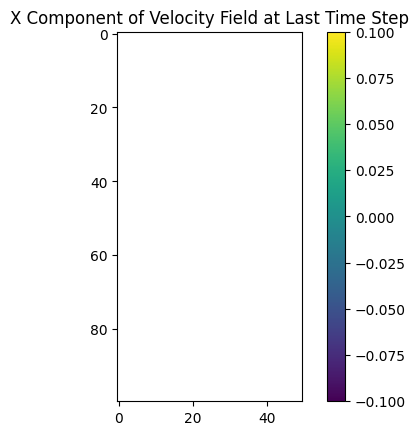

In [15]:
# Initialize arrays to store velocity components and density for all time steps
import matplotlib.pyplot as plt
uall = np.zeros((len(saved_states), nx, ny, 2))  # For both velocity components
rhoall = np.zeros((len(saved_states), nx, ny))  # For density
%matplotlib inline
# Loop to fill in the uall and rhoall arrays
for i, state in enumerate(saved_states):
    rho, u = state
    rhoall[i, :, :] = rho
    uall[i, :, :, :] = u
print(u)
# Calculate the difference in the velocity field between the first and the last state
#print(np.linalg.norm(uall[-1, :, :, :] - uall[0, :, :, :]))
#print(u)
# Visualize the x-component of the velocity field of the last state
plt.imshow(uall[-1, :, :,0])
plt.colorbar()
plt.title("X Component of Velocity Field at Last Time Step")
plt.show()

In [ ]:
uparabolic=uall[-1,50,:,0]
print(uparabolic)
plt.plot(uparabolic)

[[0.99956197 0.99956203 0.9995622  ... 0.99956238 0.99956244 0.99956226]
 [0.99956197 0.99956203 0.9995622  ... 0.99956238 0.99956244 0.99956226]
 [0.99956197 0.99956203 0.9995622  ... 0.99956238 0.99956244 0.99956226]
 ...
 [0.99956197 0.99956203 0.9995622  ... 0.99956238 0.99956244 0.99956226]
 [0.99956197 0.99956203 0.9995622  ... 0.99956238 0.99956244 0.99956226]
 [0.99956197 0.99956203 0.9995622  ... 0.99956238 0.99956244 0.99956226]]


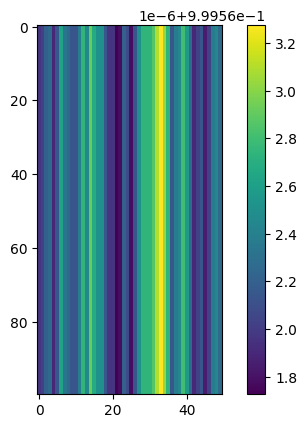